In [ ]:
## 일반 패키지 ##
import sys
import time
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import sys
import time
import pandas as pd
import numpy as np
import os
from math import log
import warnings
#import pillow
warnings.filterwarnings(action='ignore')

### 워드클라우드 및 시각화 관련 패키지 ###
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# 말뭉치 분석 및 명사 추출 패키지 #
from konlpy.tag import Kkma       ; kkma = Kkma()
from konlpy.tag import Hannanum   ; hannanum = Hannanum()
from konlpy.tag import Okt        ; t = Okt()
from konlpy.tag import *
import pickle

## 텍스트 통계분석 패키지 ##
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


## word2vec 관련 패키지 ##
import gensim
from gensim.models import Word2Vec


from apyori import apriori
import networkx as nx
from collections import Counter
from PIL import Image
from PIL import Image, ImageDraw, ImageFilter, ImageFont
# Keep in mind the background of the image used must be white



# 그림 옵션 지정 부분 #
plt.rcParams ['font.family'] = [ 'sans-serif']
plt.rcParams ['font.sans-serif'] = ['Malgun Gothic']
plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['axes.grid'] = False
csfont = {'fontname':'Malgun Gothic'}
# 그림 옵션 지정 부분 #

<h1>워드클라우드</h1>

In [20]:
keyword = ['result2']
stopwords = pd.read_csv("./stopwords.txt",encoding='utf-')
stopwordsList = list(stopwords.stopwords)

for k in keyword:
    print(k)
    # 파일을 읽기
    data_all = pd.read_csv('./OUTPUT/SSG/'+k+'.csv')
    #print(data_all)
    
    sangpum = np.unique(data_all['PRODUCT_NAME'])
    
    for ss in sangpum:
    
        data = data_all[data_all['PRODUCT_NAME'] == ss]
        data.reset_index(drop=True, inplace=True)
        print(data)
        
        # 단어가 없는 경우 넘어가기 위한 장치
        def isNaN(string):
            return string != string

        # 리뷰 파일로부터 한국어의 명사 추출 (이는 TF-IDF를 구하기 전 전처리를 위함)
        content = data['REVIEW']

        content_result = []
        count = -1
        for i in content:
            check = isNaN(i)
            if check == True:
                continue

            content_part = kkma.nouns(i) # 각 내용으로부터 명사 추출

            for j in content_part:

                if(len(j) == 1):
                    continue
                elif(j in stopwordsList):
                    continue

                try:
                    aa = float(j)
                    continue;
                except ValueError:
                    aa=1

                count = count + 1
                content_result.append(0)
                content_result[count] = j # 각 내용으로부터 명사 저장


        content = data['REVIEW']
        content_result_unique = list(set(content_result)) # 중복 제거

        N = len(content) # 총 문서의 수

        def tf(t, d):
            return d.count(t)

        def idf(t,docs):
            df = 0
            for doc in docs:
                #print(doc)
                df += t in doc
            return log(N/(df + 1))

        def tfidf(t, d,docs):
            return tf(t,d)* idf(t,docs)


        result = []
        for i in range(N): # 각 문서에 대해서 아래 명령을 수행

            result.append([])
            d = content[i]

            for j in range(len(content_result_unique)):
                t = content_result_unique[j]        
                result[-1].append(tf(t, d))

        tf_ = pd.DataFrame(result, columns = content_result_unique)

        result = []
        print(content)
        for j in range(len(content_result_unique)):
            t = content_result_unique[j]
            result.append(idf(t,content))

        idf_ = pd.DataFrame(result, index = content_result_unique, columns = ["IDF"])
        idf_ = idf_.sort_values(by=['IDF'], axis=0, ascending=True)

        idf_.to_excel("./단어중요도(IDF)_" + k + "_결과.xlsx")

        d = {}
        count = -1
        for i in idf_.index:
            count = count + 1
            d[i] = idf_['IDF'][count] * -1 
            if( d[i] > 0  ):
                d[i] = -0.001


        plt.rc('font', family='NanumGothic') # For Windows
        wordcloud = WordCloud(font_path='malgun.ttf',
                            background_color="white",scale=3)
        wordcloud.generate_from_frequencies(frequencies=d)
        #plt.figure(figsize=(10,10),dpi=300)
        plt.figure(figsize = (20,10), dpi = 600)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.tight_layout(pad=0)
        #plt.show()
        plt.savefig("./OUTPUT/WORDCLOUD/"+ss+"_워드클라우드.png",width = 1600, height = 800, dpi = 300)
    

<h1>감성분석</h1>

In [21]:
# 미리 평점이 있는 화장품 리뷰 데이터 읽기
df = pd.read_csv('./감성분석입력자료/감성분석_인풋.csv')
df

,content,rating
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,5
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",5
2,폴리스스토리 시리즈는 5부터 뉴까지 버릴께 하나도 없음.. 최고.,5
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,5
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,5
...,...,...
199995,포켓 몬스터 짜가 ㅡㅡ;;,1
199996,쓰.레.기,1
199997,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,1
199998,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,1


In [22]:
# 평점 전처리 함수
def star_preprocessing(value) :
#     value = int(text)

    if value <= 3 :
        return '0'
    else :
        return '1'

# 형태소 분석을 위한 함수
def tokenizer(text) :
    okt = Okt()
    return okt.morphs(text)

In [27]:
def step1_data_preprocessing() :
    # 수집한 데이터를 읽어온다.
    df = pd.read_csv('./감성분석입력자료/cos27.txt')

    # 전처리를 수행한다.
    df['rating'] = df['rating'].apply(star_preprocessing)

    # 학습데이터와 테스트 데이터로 나눈다.
    text_list = df['content'].tolist()
    star_list = df['rating'].tolist()

    from sklearn.model_selection import train_test_split

    # 80%는 학습, 20%는 test
    text_train, text_test, star_train, star_test = train_test_split(text_list, star_list, test_size=0.2, random_state=0)

    return text_train, text_test, star_train, star_test

In [24]:
def step2_learning(X_train, y_train, X_test, y_test):
    # 주어진 데이터를 단어 사전으로 만들고 각 단어의 빈도수를 계산한 후 벡터화 하는 객체 생성
    tfidf = TfidfVectorizer(lowercase=False, tokenizer=tokenizer)

    # 문장별 나오는 단어수 세서 수치화, 벡터화해서 학습을 시킨다.
    logistic = LogisticRegression(C=10.0, penalty='l2', random_state=0)

    pipe = Pipeline([('vect', tfidf), ('clf', logistic)])

    # 학습한다.
    pipe.fit(X_train, y_train)

    # 학습 정확도 측정
    y_pred = pipe.predict(X_test)
    print(accuracy_score(y_test, y_pred))

    # 학습된 모델을 저장한다.
    with open('pipe.dat', 'wb') as fp :
        pickle.dump(pipe, fp)
        
    print('저장완료')

In [25]:
def step3_using_model(text) :
    # 객체를 복원한다.
    with open('pipe.dat', 'rb') as fp:
        pipe = pickle.load(fp)

    str = [text]
    # 예측 정확도
    r1 = np.max(pipe.predict_proba(str) * 100)
    # 예측 결과
    r2 = pipe.predict(str)[0]
    
    res = [r1,r2]
    #print('정확도 : %.3f' % r1)
    
    return res

        
# 학습 함수
def learing() :
    text_train, text_test, star_train, star_test = step1_data_preprocessing()
    step2_learning(text_train, star_train, text_test, star_test)

# 사용 함수
def using(inputtext) :
    res = step3_using_model(inputtext)
    return res

In [28]:
learing() # 학습 수행

0.8
저장완료


In [34]:
keyword = ['result2']

for k in keyword:

    print(k)
    # 파일을 읽기
    data_all = pd.read_csv('./OUTPUT/SSG/'+k+'.csv')
    sangpum = np.unique(data_all['PRODUCT_NAME'])
    
    for ss in sangpum:

        data = data_all[data_all['PRODUCT_NAME'] == ss]
        data.reset_index(drop=True, inplace=True)
        #print(data)

        data['긍부정결과'] = ""
        data['정확도'] = ""
        content = data['REVIEW']

        count = -1

        for i in content:

            count = count + 1
            res1 = using(i)

            if (res1[1] == "1"):
                data['긍부정결과'][count] = "긍정"
                data['정확도'][count] = res1[0] 
            else:
                data['긍부정결과'][count] = "부정"
                data['정확도'][count] = res1[0] 


        data.to_excel("./감성분석결과/" + ss + "_감성분석결과.xlsx")
    

result2


<h1>감성분석 시각화 (파이차트)</h1>

In [40]:
keyword = sangpum
import matplotlib as mpl
mpl.rcParams['font.size'] = 24
plt.rcParams['savefig.facecolor']='white'
mpl.rcParams['font.family'] ='Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] =False

for k in sangpum:
    print(k)
    # 파일을 읽기
    ratio = []
    data = pd.read_excel('./감성분석결과/'+k+'_감성분석결과.xlsx')
    ratio = [len(data[data['긍부정결과'] == '긍정']),len(data[data['긍부정결과'] == '부정'])]
    labels = ['긍정','부정']
    colors = ['lightskyblue', 'lightcoral']
    plt.pie(ratio, labels=labels, autopct='%.1f%%',colors=colors)
    plt.title(k+"긍부정 비율",fontsize=28)
    plt.savefig("./긍부정비율_"+k+".png",dpi=600)
    plt.close()

    

CJ 미정당 매콤까르보나라 누들떡볶이400g
CJ 미정당국물떡볶이401.2g
CJ 미정당순쌀떡볶이401.2g
[노브랜드] 간장 떡볶이 402.5g
[노브랜드] 떡볶이 402.5g
[청정원] 달인 기름떡볶이 420g
[청정원] 달인 왕떡볶이 420g
[풀무원] 국물 떡볶이 423.5g (2인분)
농심 쿡탐 짜파게티맛 국물떡볶이 380g
대림 국물떡볶이 373g
대림 로제떡볶이 343g
대림 짜장떡볶이 343g
동원 떡볶이의신 신당동 즉석쫄볶이397g
동원 떡볶이의신 즉석라볶이 404g
청정원 야식이夜베이컨&로제떡볶이 485g
풀무원 달콤고추장크림 누들떡볶이375g
풀무원 말랑말랑 밀누들 떡볶이(국물떡볶이 소스)
피코크 BT21 매운치즈떡볶이605g
피코크 피콕분식 국물떡볶이430g
피코크 피콕분식 신당동식떡볶이970g


<h1>단어 네트워크</h1>

result2
     NO  INDEX  SCORE                                             REVIEW  \
0   801   1811      5  세상참 좋아졌죠??예전엔 떡볶이해주려면 고추장풀고 여러가지 양념하구 ..시간도 시간...   
1   802   1810      4  매콤까르보나라누들떡볶이 떡이랑소스가 들어있구요 떡을 찬물에 담그고 붙어있는떡을 떼는...   
2   803   1809      5  Cj 묻고싶네여 언제부터 이 양이 2인분 이었죠..? 너무 맛있으니까 진짜 2인분치...   
3   804   1808      5  맛있어요 항상 주문합니다 떡에 소스가 가장 잘 베는듯 다른 제품들은 떡의 밀가루맛이...   
4   805   1807      4  솔직히 2인분은아닌것같아요 저 대식가는아닌데 혼자거의다먹었는데.. ㅎㅎㅎㅎ 칼로리가...   
..  ...    ...    ...                                                ...   
95  896   1726      5  저는 이제품 조리해 먹을 때 추가로 당면넣고 캡사**을 넣고 먹었는데 캡사**을 너...   
96  897   1725      4  양념자체는 맛있어요~ 이름만보고 로제파스타 소스 느낌이 떠올랐는데 전체적인 맛은 고...   
97  898   1724      5                  국물을 넉넉히잡고조리하니먹을만해요 까르보나라맛이마니나서맛나요   
98  899   1723      5                                       처음 먹어?는데 맛나요   
99  900   1722      5                                     좋아요. 항상 만족합니다.   

     REVIEW_ID REVIEW_DATE MARKET_PLATFORM  \
0   eun*******  2021-06-03       

KeyboardInterrupt: 

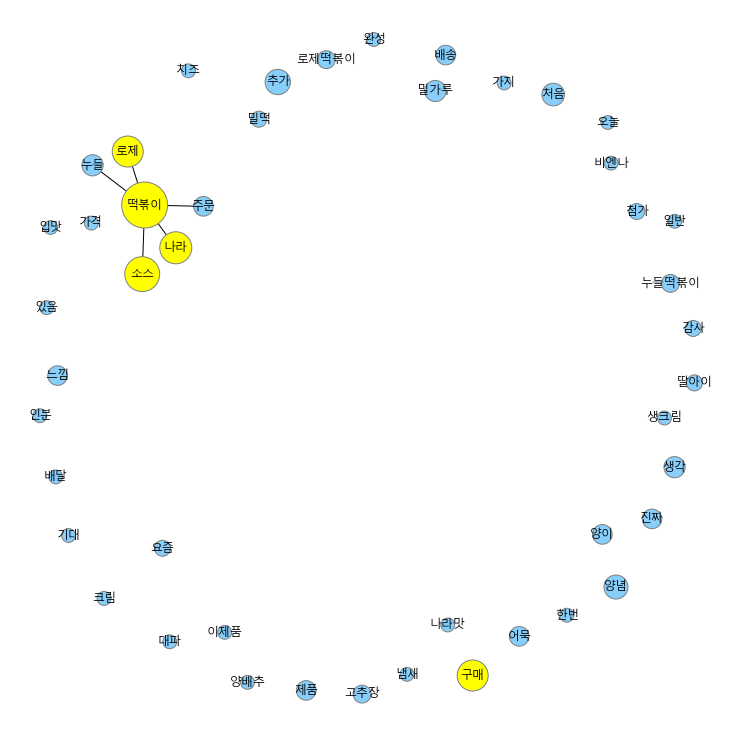

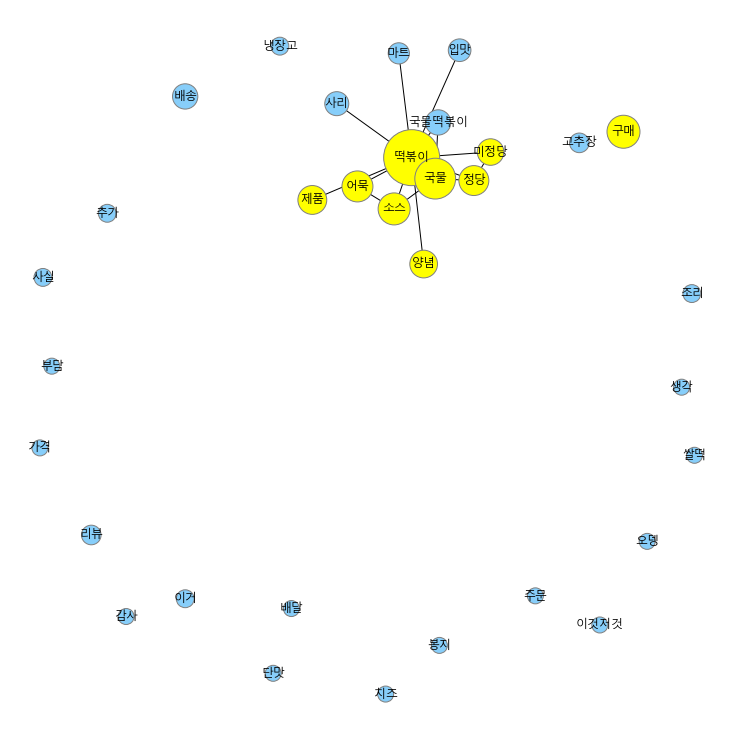

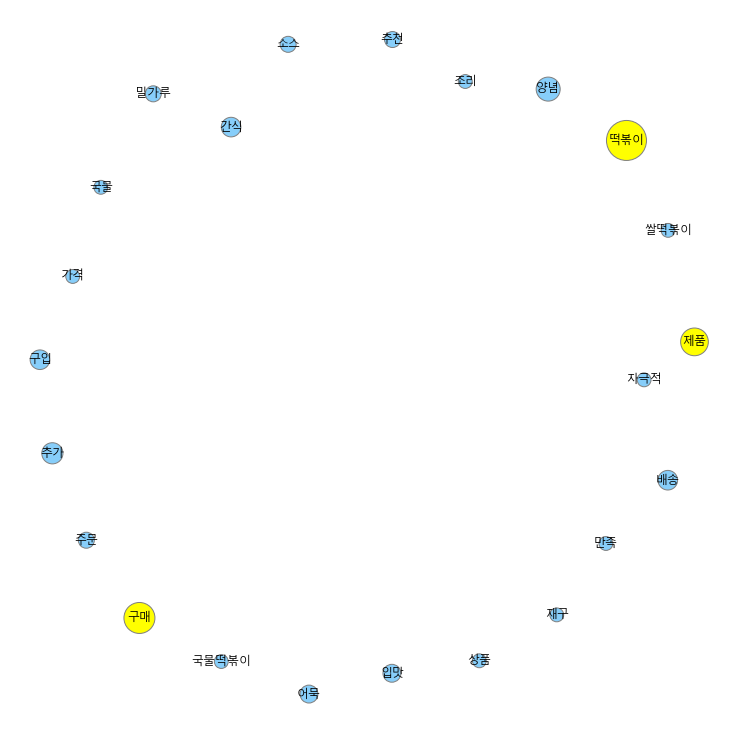

In [29]:
keyword = ['result2']
stopwords = pd.read_csv("./stopwords.txt")
stopwordsList = list(stopwords.stopwords)

# 단어가 없는 경우 넘어가기 위한 장치
def isNaN(string):
    return string != string

for k in keyword:
    
    print(k)
    # 파일을 읽기
    data_all = pd.read_csv('./OUTPUT/SSG/'+k+'.csv')
    sangpum = np.unique(data_all['PRODUCT_NAME'])
    
    for ss in sangpum:

        data = data_all[data_all['PRODUCT_NAME'] == ss]
        data.reset_index(drop=True, inplace=True)
        print(data)

        content = data['REVIEW']

        content_result = []
        count = -1
        counti = -1
        for i in content:
            check = isNaN(i)
            if check == True:
                continue

            counti = counti + 1
            content_part = kkma.nouns(i) # 각 내용으로부터 명사 추출
            content_result.append([])

            for j in content_part:

                if(len(j) == 1):
                    continue
                elif(j in stopwordsList):
                    continue


                try:
                    aa = float(j)
                    continue;
                except ValueError:
                    aa=1

                count = count + 1
                content_result[counti].append(j)

        # 연관 분석을 수행합니다.
        results = list(apriori(content_result,
            min_support=0.06,
            min_confidence=0.05,
            min_lift=1.0,
            max_length=2))


        # 데이터 프레임 형태로 정리합니다.
        columns = ['source', 'target', 'support']
        network_df = pd.DataFrame(columns=columns)

        # 규칙의 조건절을 source, 결과절을 target, 지지도를 support 라는 데이터 프레임의 피처로 변환합니다.
        for result in results:
            if len(result.items) == 2:
                items = [x for x in result.items]
                row = [items[0], items[1], result.support]
                series = pd.Series(row, index=network_df.columns)
                network_df = network_df.append(series, ignore_index=True)

        content_result2 = []
        count = -1
        for i in content:
            check = isNaN(i)
            if check == True:
                continue

            content_part = kkma.nouns(i) # 각 내용으로부터 명사 추출

            for j in content_part:

                if(len(j) == 1):
                    continue
                elif(j in stopwordsList):
                    continue

                try:
                    aa = float(j)
                    continue;
                except ValueError:
                    aa=1

                count = count + 1
                content_result2.append(0)
                content_result2[count] = j # 각 내용으로부터 명사 저장


        # 한글자 키워드를 제거합니다.
        count = Counter(content_result2)

        # 한글자 키워드를 제거합니다.
        remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})

        # 키워드와 키워드 빈도 점수를 ‘node’, ‘nodesize’ 라는 데이터 프레임의 피처로 생성합니다.
        node_df = pd.DataFrame(remove_char_counter.items(), columns=['node', 'nodesize'])

        sizefilter = 0

        for i in range(0,10000):
            sizefilter = sizefilter + 1
            node_df = node_df[node_df['nodesize'] >= sizefilter] # 시각화의 편의를 위해 ‘nodesize’ 이하는 제거합니다. (상위 50개)

            if(len(node_df) >= 50 ):
                continue
            else:
                break

        node_df.head()
        node_df.reset_index(inplace=True)
        len(node_df)
        print(node_df)

        plt.figure(figsize=(10,10))

        # networkx 그래프 객체를 생성합니다.
        G = nx.Graph()

        sizes = []

        # node_df의 키워드 빈도수를 데이터로 하여, 네트워크 그래프의 ‘노드’ 역할을 하는 원을 생성합니다.
        for index, row in node_df.iterrows():

            G.add_node(row['node'], nodesize=row['nodesize'])
            sizes.append(row['nodesize'])


        # network_df의 연관 분석 데이터를 기반으로, 네트워크 그래프의 ‘관계’ 역할을 하는 선을 생성합니다.
        for index, row in network_df.iterrows():
            G.add_weighted_edges_from([(row['source'], row['target'], row['support'])])

        # 그래프 디자인과 관련된 파라미터를 설정합니다.
        #pos = nx.spring_layout(G, k=0.6, iterations=50)
        pos = nx.spring_layout(G)
        node_df['nodesize'].fillna(value=node_df['nodesize'].mean(), inplace=True)

        sizes = []
        colors = []
        for node in G:
            try:
                sizes.append(G.nodes[node]['nodesize']*64)
            except:
                sizes.append(500)
                continue


        for size in sizes:
            if(size > 10*64):
                colors.append("yellow")
            else:
                colors.append("lightskyblue")

        nx.draw(G, pos=pos, node_size=sizes,node_color=colors, edgecolors='gray')
        #nx.draw(G, pos=pos, node_size=sizes,node_color="cyan", edgecolors='gray')
        nx.draw_networkx_labels(G, pos=pos, font_family="sans-serif", font_size=12)


        # 그래프를 출력합니다.
        ax = plt.gca()
        plt.savefig("./단어네트워크_"+k+".png",dpi=600)

